In [62]:
import os
import sys
sys.path.append(".")
sys.path.append("..")
from feature_importance.scripts.simulations_util import *
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pickle
import numpy as np
import pandas as pd
import sys
import shap
from sklearn.model_selection import train_test_split

In [63]:
np.random.seed(0)

In [64]:
X = sample_normal_X(500,300,10,seed=42)

In [65]:
# Do linear model where the first 5 features are important for the first subgroup and the last 5 features are important for the second subgroup
y = linear_model_two_groups(X, s=5, beta=1, sigma=None, heritability=0.4,seed=8, group_intercept=0.5)

In [66]:
X_train_subgroup1, X_test_subgroup1, y_train_subgroup1, y_test_subgroup1 = train_test_split(X[:X.shape[0]//2], y[:y.shape[0]//2], test_size=0.3, random_state=0)

In [67]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=42)
rf.fit(X_train_subgroup1, y_train_subgroup1)
# Measure the performance of the model
y_pred = rf.predict(X_test_subgroup1)
#MSE
mse = np.mean((y_test_subgroup1 - y_pred)**2)
#R2
r2 = rf.score(X_test_subgroup1, y_test_subgroup1)
print(f"MSE: {mse}, R2: {r2}")

MSE: 0.08147459091310877, R2: 0.3078690573523587


In [68]:
X_train_subgroup2, X_test_subgroup2, y_train_subgroup2, y_test_subgroup2 = train_test_split(X[X.shape[0]//2:], y[y.shape[0]//2:], test_size=0.3, random_state=0)

In [69]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=42)
rf.fit(X_train_subgroup2, y_train_subgroup2)
# Measure the performance of the model
y_pred = rf.predict(X_test_subgroup2)
#MSE
mse = np.mean((y_test_subgroup2 - y_pred)**2)
#R2
r2 = rf.score(X_test_subgroup2, y_test_subgroup2)
print(f"MSE: {mse}, R2: {r2}")

MSE: 0.0895600097001882, R2: 0.20958625064562153


In [70]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [71]:
# rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=42)
# rf.fit(X_train, y_train)
# # Measure the performance of the model
# y_pred = rf.predict(X_test)
# #MSE
# mse = np.mean((y_test - y_pred)**2)
# #R2
# r2 = rf.score(X_test, y_test)
# print(f"MSE: {mse}, R2: {r2}")

In [72]:
num_rows = X.shape[0]

# Create the new column
new_column = np.zeros(num_rows)
new_column[num_rows // 2:] = 1

# Reshape the new column to be a column vector
new_column = new_column.reshape(-1, 1)
new_X = np.hstack((X, new_column))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=300, random_state=0)

In [74]:
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=0.33, random_state=42)
rf.fit(X_train, y_train)
# Measure the performance of the model
y_pred = rf.predict(X_test)
#MSE
mse = np.mean((y_test - y_pred)**2)
#R2
r2 = rf.score(X_test, y_test)
print(f"MSE: {mse}, R2: {r2}")

MSE: 0.12103227948790433, R2: 0.6834610363577607


In [75]:
from sklearn.metrics import r2_score
r2_score(y_test, rf.predict(X_test))

0.6834610363577607

In [50]:
features = [0,0,0,0,0,0,0,0,0,0,0]
for i, tree in enumerate(rf.estimators_):
    root_feature_index = tree.tree_.feature[0]
    features[root_feature_index] += 1
print(features)

[6, 4, 14, 6, 11, 6, 12, 2, 4, 1, 34]


In [51]:
# rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, max_features=1.0, random_state=42)
# rf.fit(X_train, y_train)
# # Measure the performance of the model
# y_pred = rf.predict(X_test)
# #MSE
# mse = np.mean((y_test - y_pred)**2)
# #R2
# r2 = rf.score(X_test, y_test)
# print(f"MSE: {mse}, R2: {r2}")

In [52]:
# features = [0,0,0,0,0,0,0,0,0,0,0]
# for i, tree in enumerate(rf.estimators_):
#     root_feature_index = tree.tree_.feature[0]
#     features[root_feature_index] += 1
# print(features)

In [53]:
rf_plus_base = RandomForestPlusRegressor(rf_model=rf)
rf_plus_base.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished


In [54]:
y_pred = rf_plus_base.predict(X_test)
#MSE
mse = np.mean((y_test - y_pred)**2)
#R2
r2 = rf_plus_base.score(X_test, y_test)
print(f"MSE: {mse}, R2: {r2}")

MSE: 0.10835801043701464, R2: 0.7166083918175286


In [55]:
X_test_subgroup1 = X_test[X_test[:,-1] == 0]
y_test_subgroup1 = y_test[X_test[:,-1] == 0]
X_test_subgroup2 = X_test[X_test[:,-1] == 1]
y_test_subgroup2 = y_test[X_test[:,-1] == 1]

y_pred_subgroup1 = rf.predict(X_test_subgroup1)
y_pred_subgroup2 = rf.predict(X_test_subgroup2)

#MSE
mse_subgroup1 = np.mean((y_test_subgroup1 - y_pred_subgroup1)**2)

#R2
r2_subgroup1 = rf.score(X_test_subgroup1, y_test_subgroup1)

#MSE
mse_subgroup2 = np.mean((y_test_subgroup2 - y_pred_subgroup2)**2)

#R2
r2_subgroup2 = rf.score(X_test_subgroup2, y_test_subgroup2)

print(f"MSE subgroup1: {mse_subgroup1}, R2 subgroup1: {r2_subgroup1}")
print(f"MSE subgroup2: {mse_subgroup2}, R2 subgroup2: {r2_subgroup2}")

MSE subgroup1: 0.11207020363569249, R2 subgroup1: 0.15049926518456913
MSE subgroup2: 0.13011465166028005, R2 subgroup2: 0.019038616725601032


In [56]:
from sklearn.metrics import r2_score

In [57]:
r2_score(y_test_subgroup1, y_pred_subgroup1), r2_score(y_test_subgroup2, y_pred_subgroup2)

(0.15049926518456913, 0.019038616725601032)

/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zhongyuan_liang/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


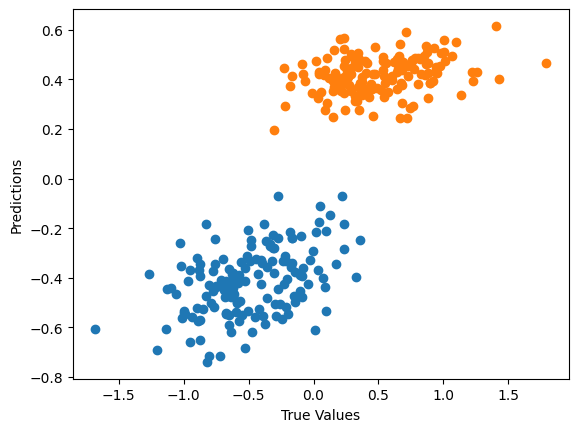

In [58]:
import matplotlib.pyplot as plt
plt.plot(y_test_subgroup1, y_pred_subgroup1, 'o')
plt.plot(y_test_subgroup2, y_pred_subgroup2, 'o')
#axis labels
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [59]:
X_test_subgroup1 = X_test[X_test[:,-1] == 0]
y_test_subgroup1 = y_test[X_test[:,-1] == 0]
X_test_subgroup2 = X_test[X_test[:,-1] == 1]
y_test_subgroup2 = y_test[X_test[:,-1] == 1]

y_pred_subgroup1 = rf_plus_base.predict(X_test_subgroup1)
y_pred_subgroup2 = rf_plus_base.predict(X_test_subgroup2)

#MSE
mse_subgroup1 = np.mean((y_test_subgroup1 - y_pred_subgroup1)**2)

#R2
r2_subgroup1 = rf_plus_base.score(X_test_subgroup1, y_test_subgroup1)

#MSE
mse_subgroup2 = np.mean((y_test_subgroup2 - y_pred_subgroup2)**2)

#R2
r2_subgroup2 = rf_plus_base.score(X_test_subgroup2, y_test_subgroup2)

print(f"MSE subgroup1: {mse_subgroup1}, R2 subgroup1: {r2_subgroup1}")
print(f"MSE subgroup2: {mse_subgroup2}, R2 subgroup2: {r2_subgroup2}")

MSE subgroup1: 0.099505377830681, R2 subgroup1: 0.24574160800106526
MSE subgroup2: 0.11732947032665475, R2 subgroup2: 0.1154287542421103
